In [44]:
import numpy as np
import time

import multiprocessing as mp

from PIL import Image
Image.MAX_IMAGE_PIXELS = None # Disable warnings for pillow DecompressionBombError

import matplotlib as mpl
import matplotlib.pyplot as plt

# larger inline images
mpl.rcParams['figure.figsize'] = (20,20)

Read some data

In [45]:
# Reading the GeoTIFF as a plain image, not caring about the georeference for now; then convert to numpy array
im = Image.open('ssp3-pop-2010.tiff')
pop2010 = np.array(im)
pop2010.shape

(16920, 43200)

Repeat for the other 3 population layers

In [46]:
im = Image.open('ssp3-pop-2030.tiff')
pop2030 = np.array(im)
pop2030.shape

(16920, 43200)

In [47]:
im = Image.open('ssp3-pop-2070.tiff')
pop2070 = np.array(im)
pop2070.shape

(16920, 43200)

In [48]:
im = Image.open('ssp3-pop-2100.tiff')
pop2100 = np.array(im)
pop2100.shape

(16920, 43200)

Calculate the difference from 2030 to 2010, and so on...

In [49]:
pop2100diff = pop2100 - pop2070
pop2070diff = pop2070 - pop2030
pop2030diff = pop2030 - pop2010

Some cells may now have negative values, we'll set them to zero for this purpose here:

In [50]:
pop2100diff[pop2100diff < 0] = 0
pop2070diff[pop2070diff < 0] = 0
pop2030diff[pop2030diff < 0] = 0

Next, we'll define a function that turns the raster into 2D points (as in the [raster2points notebook](raster2points%20-%20global%20tiff.ipynb))

In [51]:
def toPoints(raster):
    numpoints = np.sum(raster)
    points = np.zeros((numpoints,2), dtype=int)
    # make an empty 2D "target array"
    points = np.zeros((numpoints,2), dtype=int)

    # keep track of where in the target array we have to insert
    insertrow = 0

    # iterate over the input raster
    it = np.nditer(raster, flags=['multi_index'])
    while not it.finished:
        entry = np.array([np.array(it.multi_index)])
        block = np.repeat(entry, it[0], axis=0)
        points[insertrow:insertrow+block.shape[0]] = block
        insertrow = insertrow + block.shape[0]
        it.iternext()
        
    expansion = 1.5

    seed = np.random.rand(numpoints,2)
    seed = seed * expansion

    points = points + seed

    return points

Test with sub-arrays:

In [52]:
# start row/column and size of the sub-array
x = 8000
y = 25000
s= 1000

p2100 = pop2100diff[x:x+s,y:y+s]
p2070 = pop2070diff[x:x+s,y:y+s]
p2030 = pop2030diff[x:x+s,y:y+s]
p2010 = pop2010[x:x+s,y:y+s]

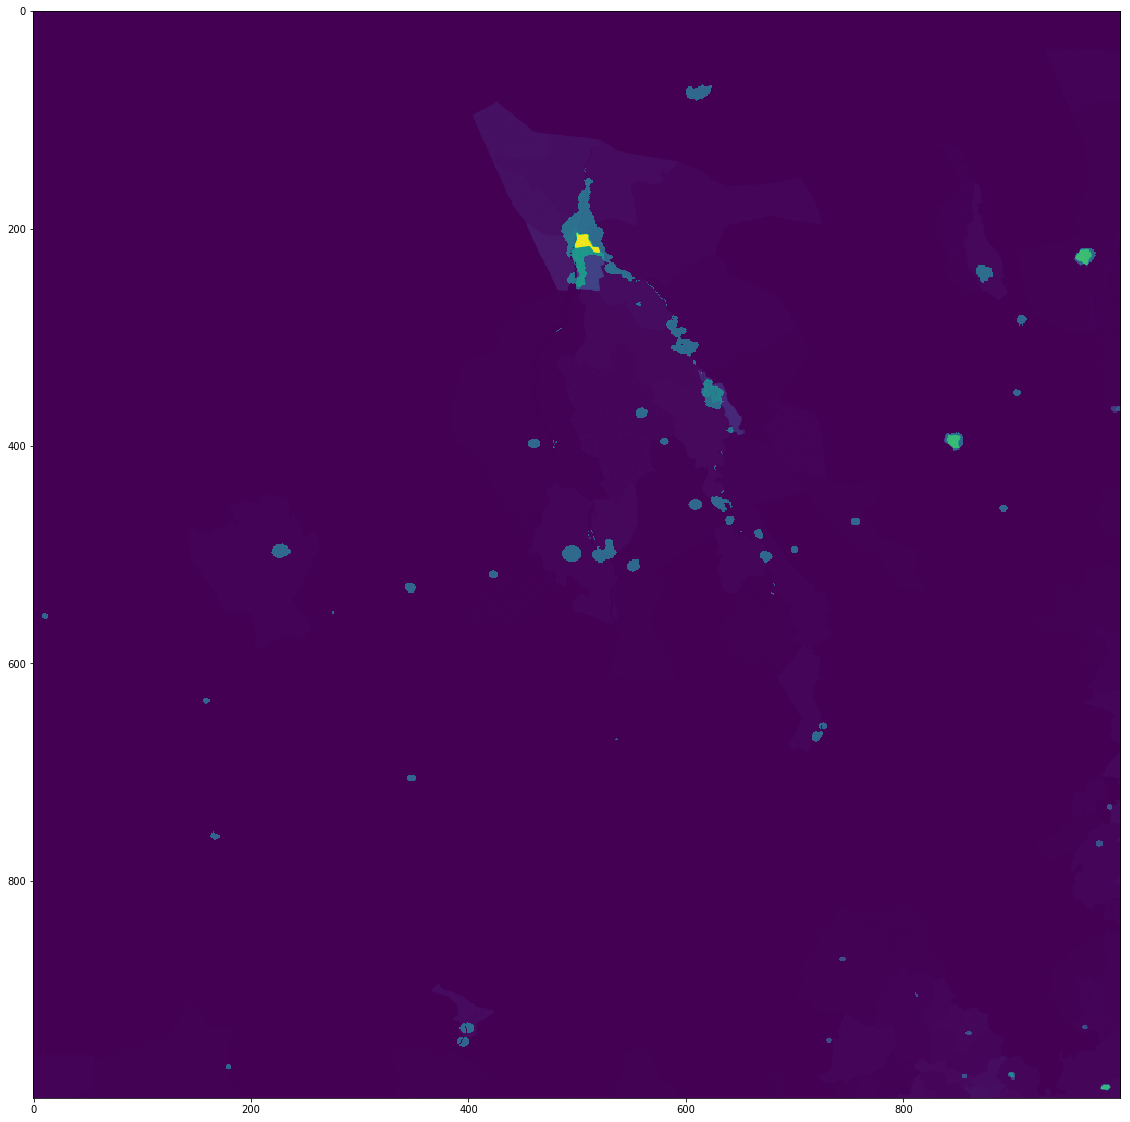

In [53]:
plt.imshow(p2010)

Quick test:

In [54]:
pts = toPoints(p2010)

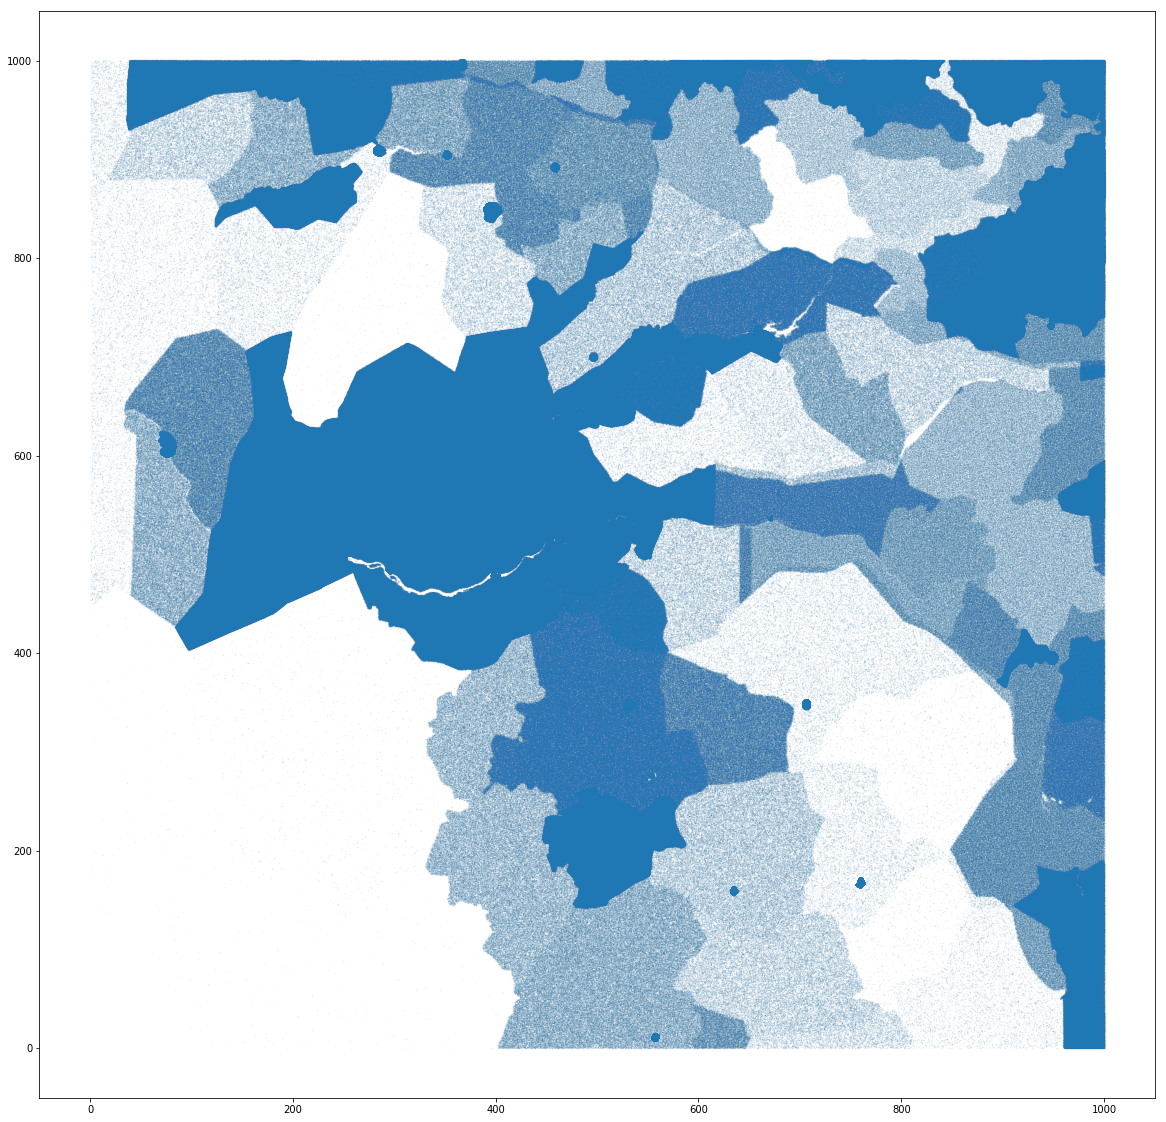

In [57]:
#TBD: There's something wrong here. Coordinates flipped?

plt.scatter(pts[:,0], pts[:,1], marker=".", s=0.01, alpha=0.5)
plt.show()

This seems to work so far. Next, we'll define a function that splits up the array into equal sub-arrays, runs the point generation in parallel, and then joins the points generated by the sub-processes back together

TBD; remember that if we split up a 2D array, the cells in the news sub-arrays have different indices than in the original array!